In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from time import time
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn import manifold
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import v_measure_score


def plot_3d_scatter(data, labels):
    '''the function creates plot_3d_scatter
    parm: data: a given data frame
    type: data: data frame
    parm: labels: labels of data frame
    type: labels: list
    return: None'''
    fig1 = plt.figure()
    ax1 = Axes3D(fig1)
    ax1.scatter(data[:,1], data[:,0], data[:,2], c = labels)
    fig2 = plt.figure()
    ax2 = Axes3D(fig2)
    ax2.scatter(data[:,0], data[:,1], data[:,2], c = labels)
    plt.show()
    
def compute_mutual_info_p_value(true_label, model_label):
    '''the function calculate p-value 
    parm input: true_label & model_label
    return: None'''
    simplefilter(action = 'ignore', category = FutureWarning)
    #ignore all future warnings
    simplefilter(action = 'ignore', category = FutureWarning)
    p = 1000
    vec = []
    real_score = normalized_mutual_info_score(true_label, model_label)
    for i in range(p):
        y_shuffle = shuffle(true_label).reset_index()
        y_shuffle = y_shuffle.drop('index', axis = 1)
        y_shuffle = y_shuffle.squeeze()
        #dummy_score = normalized_mutual_info_score(y_shuffle, model_label)
        vec.append(y_shuffle)
    p_value_s = np.array(vec)
    print('p value for normalized mutual info- ',len(p_value_s[p_value_s > real_score]) / float(1000))
    sns.distplot(p_value_s, axlabel="normalized mutual info")

Initial data shape: (101766, 50)
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide        

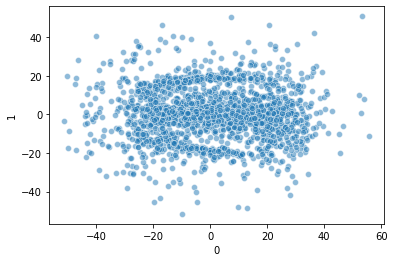

In [3]:
#Reads Data
data = pd.read_csv('C:/Users/tomer/desktop/diabetic_data.csv')
print("Initial data shape:", data.shape)  
print(data.dtypes)

#MDS
dbscan_data_check = data.copy()
dbscan_data = dbscan_data_check[['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                                 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                                 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']]
t0 = time()
mds = manifold.MDS(2, max_iter = 30, n_init = 1)
trans_data = mds.fit_transform(dbscan_data)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
print("trans_data:", trans_data)
trans_data = pd.DataFrame(trans_data)
plt.figure(30)
sns.scatterplot(x = 0, y = 1, data = trans_data, palette = sns.color_palette("hls", 2), alpha = 0.5, legend = "full")

In [3]:
print(data.head(10))

   encounter_id  patient_nbr             race  gender       age weight  \
0       2278392      8222157        Caucasian  Female    [0-10)      ?   
1        149190     55629189        Caucasian  Female   [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female   [20-30)      ?   
3        500364     82442376        Caucasian    Male   [30-40)      ?   
4         16680     42519267        Caucasian    Male   [40-50)      ?   
5         35754     82637451        Caucasian    Male   [50-60)      ?   
6         55842     84259809        Caucasian    Male   [60-70)      ?   
7         63768    114882984        Caucasian    Male   [70-80)      ?   
8         12522     48330783        Caucasian  Female   [80-90)      ?   
9         15738     63555939        Caucasian  Female  [90-100)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                       

In [9]:
#Data Cleaning
none_kinds = ['?', 'NULL', 'None']
data = data.replace(to_replace = none_kinds, value = np.nan) #replace Null strings to numpy NaN object

#replace NULL ids according to mappings desciription 
admission_type_id_null_values = [5, 6, 8]
discharge_disposition_id_null_values = [18, 25, 26]
admission_source_id_null_values = [9, 17, 20, 21]
data['admission_type_id'] = data['admission_type_id'].replace(to_replace = admission_type_id_null_values, value = np.nan)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(to_replace = discharge_disposition_id_null_values, value = np.nan)
data['admission_source_id'] = data['admission_source_id'].replace(to_replace = admission_source_id_null_values, value = np.nan)

#drop every feature that as less than 80% data
print(data.isnull().sum() / data.shape[0]) #check for data sparse precentage 
features_to_remove = (data.isnull().sum() / data.shape[0]) > 0.2
features_to_remove = features_to_remove[features_to_remove].index.values
print("Removed features:", features_to_remove)
data.drop(features_to_remove, axis = 1, inplace = True)

#remove Nan
data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].fillna(0)
data['race'] = data['race'].fillna('Unknown')
print("percentage of Nan's according the entire data:", data.isnull().values.ravel().sum() / data.shape[0]) 
data = data.dropna()
#remove Unknown/Invalid
data = data[data['gender'] != 'Unknown/Invalid']
print("Data shape after cleaning step:", data.shape)

#handle data duplications of records
print(len(data['patient_nbr'].unique()), len(data['encounter_id'].unique()))
data = data.drop_duplicates(subset = 'patient_nbr', keep = 'first')

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.102156
discharge_disposition_id    0.045988
admission_source_id         0.069444
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.947468
A1Cresult                   0.832773
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
c

gender
Female    37480
Male      32933
dtype: int64


<Figure size 432x288 with 0 Axes>

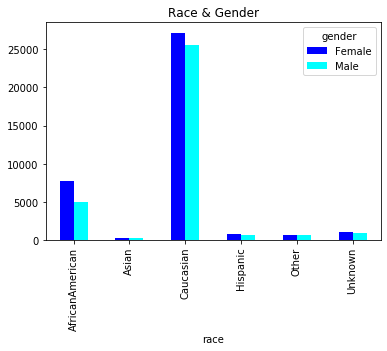

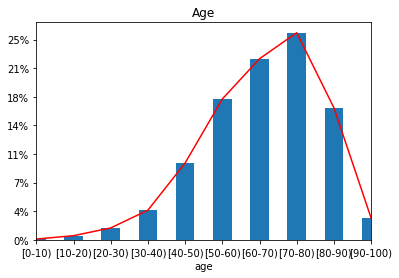

readmitted        <30    >30     NO
race                               
AfricanAmerican  1085   3819   7750
Asian              41    106    338
Caucasian        4791  16955  31016
Hispanic          118    408    948
Other              77    307    776
Unknown           138    423   1317
AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 432x288 with 0 Axes>

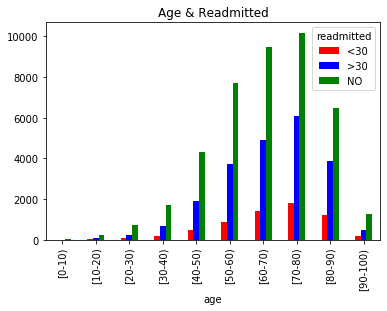

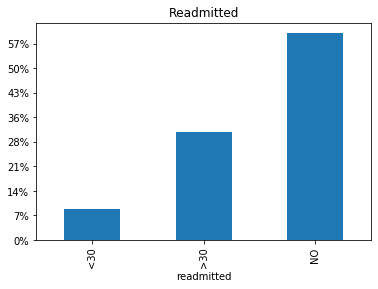

In [5]:
#Statistics Of The Data Set
print(data.groupby('gender').size())
plt.figure(4)
pd.crosstab(data['race'], data['gender']).plot(kind = 'bar', title = 'Race & Gender', color = ['blue','cyan'])
plt.figure(6)
ax = data.groupby('age').size().plot(kind = 'bar',title = 'Age')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
data.groupby('age').size().plot.line(color = 'red')
plt.show()
plt.figure(7)
pd.crosstab(data['age'], data['readmitted']).plot(kind = 'bar', title = 'Age & Readmitted', color = ['red', 'blue', 'green'])
print(pd.crosstab(data['race'], data['readmitted']))
plt.figure(9)
ax = data.groupby('readmitted').size().plot(kind = 'bar', title = 'Readmitted')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / data.shape[0]) for x in vals])
print(ax)

diabetesMed    No    Yes
age                     
[0-10)         15     49
[10-20)        60    300
[20-30)       245    792
[30-40)       688   1901
[40-50)      1629   5082
[50-60)      2842   9461
[60-70)      3545  12277
[70-80)      4265  13831
[80-90)      3052   8481
[90-100)      619   1279
count    70413.000000
mean         4.316703
std          2.956908
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         14.000000
Name: time_in_hospital, dtype: float64


<Figure size 432x288 with 0 Axes>

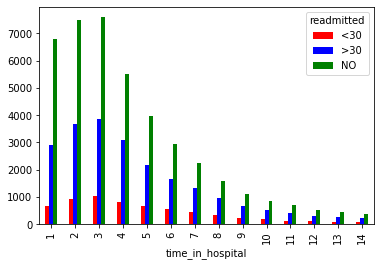

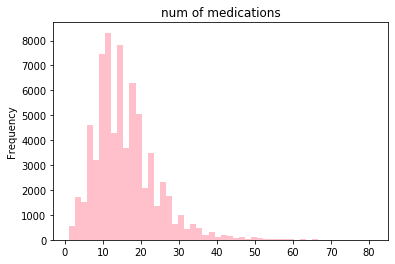

In [6]:
plt.figure(10)
pd.crosstab(data['time_in_hospital'], data['readmitted']).plot(kind = 'bar', color = ['red', 'blue', 'green'])
#plt.figure(10)
#pd.crosstab(data['readmitted'], data['change']).plot(kind = 'bar', title = 'Change & Readmitted', color = ['green', 'red'])
print(pd.crosstab(data['age'], data['diabetesMed']))
print(data['time_in_hospital'].describe())
plt.figure(12)
data['num_medications'].plot.hist(bins = 50, histtype = 'stepfilled', color = 'pink', title = 'num of medications')
plt.show()

In [10]:
#Preprocessing The Data 
categorical_data = data.select_dtypes('object')
numeric_data = data[list(filter(lambda col: col not in categorical_data.columns, data.columns))]

#handle categorical data
drugs_data = categorical_data[['metformin', 'citoglipton', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']]
for col in drugs_data.columns:
    drugs_data[col] = drugs_data[col].apply(lambda val: 0 if val == 'No' or val == 'Steady' else 1)
categorical_data['number_drugs_changed'] = drugs_data.sum(axis = 1)
categorical_data = categorical_data.drop(drugs_data.columns, axis = 1)

categorical_data['gender'] = categorical_data['gender'].replace('Male', 1)
categorical_data['gender'] = categorical_data['gender'].replace('Female', 0)
categorical_data['change'] = categorical_data['change'].replace('Ch', 1)
categorical_data['change'] = categorical_data['change'].replace('No', 0)
categorical_data['diabetesMed'] = categorical_data['diabetesMed'].replace('Yes', 1)
categorical_data['diabetesMed'] = categorical_data['diabetesMed'].replace('No', 0)
categorical_data['readmitted'] = categorical_data['readmitted'].replace('NO', 0)
categorical_data['readmitted'] = categorical_data['readmitted'].replace('>30', 0)
categorical_data['readmitted'] = categorical_data['readmitted'].replace('<30', 1)

categorical_data['age'] = categorical_data['age'].replace('[0-10)', 5)
categorical_data['age'] = categorical_data['age'].replace('[10-20)', 15)
categorical_data['age'] = categorical_data['age'].replace('[20-30)', 25)
categorical_data['age'] = categorical_data['age'].replace('[30-40)', 35)
categorical_data['age'] = categorical_data['age'].replace('[40-50)', 45)
categorical_data['age'] = categorical_data['age'].replace('[50-60)', 55)
categorical_data['age'] = categorical_data['age'].replace('[60-70)', 65)
categorical_data['age'] = categorical_data['age'].replace('[70-80)', 75)
categorical_data['age'] = categorical_data['age'].replace('[80-90)', 85)
categorical_data['age'] = categorical_data['age'].replace('[90-100)', 95)
   
race_dummies_data = pd.get_dummies(categorical_data['race'])
categorical_data = categorical_data.drop('race', axis = 1)
categorical_data = pd.concat([categorical_data, race_dummies_data], axis = 1)

#handle numeric data
#combining the 'admission_type_id' categories 2->1 and 7->1
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(2, 1)
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(7, 1)
#reanme numbers to categories
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(0, 'Not Available')
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(1, 'Emergency')
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(3, 'Elective')
numeric_data['admission_type_id'] = numeric_data['admission_type_id'].replace(4, 'Newborn')
numeric_data = pd.get_dummies(numeric_data, 'admission_type_id')
numeric_data = numeric_data.drop(['discharge_disposition_id', 'admission_source_id'], axis = 1)

combined_data = pd.concat([numeric_data, categorical_data], axis = 1)
combined_data = combined_data.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)
combined_data = combined_data.set_index(['encounter_id', 'patient_nbr'])

#using standard scaler
numeric_not_binary_columns = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'number_drugs_changed']
scaler = StandardScaler()
scaler.fit(combined_data[numeric_not_binary_columns])
combined_data[numeric_not_binary_columns] = scaler.transform(combined_data[numeric_not_binary_columns])

C:\Users\tomer\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tomer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\tomer\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

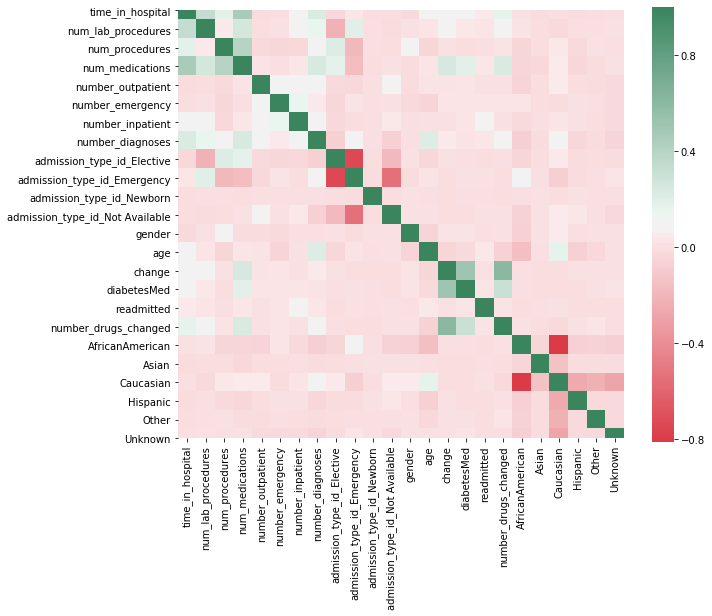

In [8]:
f, ax = plt.subplots(figsize = (10, 8))
corr = combined_data.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(10, 145, as_cmap = True), square = True, ax = ax)
#combined_data.hist()  #histograms of every colomn after pre-processing

In [9]:
#Clustering Part
#K-Means Clustering
silhouette_scores = {}
elbow_scores = {}
for k in range(2,9):
    kmeans_model = KMeans(n_clusters = k, n_jobs = -1)
    kmeans_model.fit(combined_data.values)
    elbow_scores.update({k:kmeans_model.inertia_})
    silhouette_score_val = silhouette_score(combined_data, kmeans_model.labels_)
    silhouette_scores.update({k:silhouette_score_val})

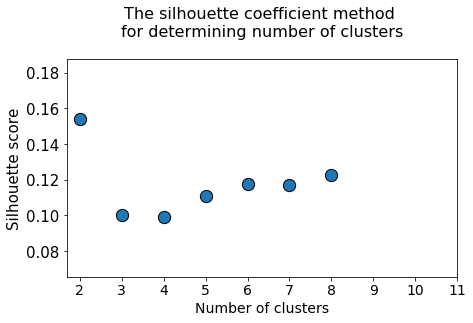

In [10]:
#Sןilouhette score
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=list(silhouette_scores.keys()),y=list(silhouette_scores.values()),s=150,edgecolor='k')
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Text(0, 0.5, 'Sum of squared distance')

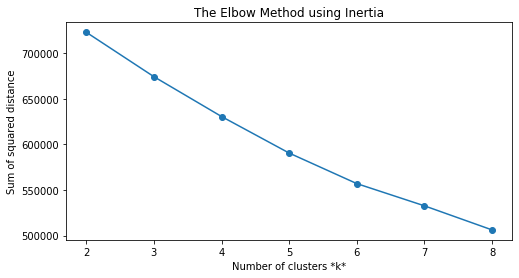

In [11]:
plt.figure(figsize=(8, 4))
plt.title('The Elbow Method using Inertia') 
plt.plot(list(elbow_scores.keys()),list(elbow_scores.values()), '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

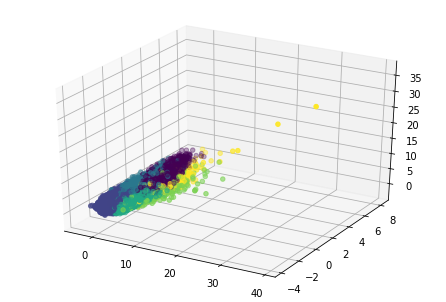

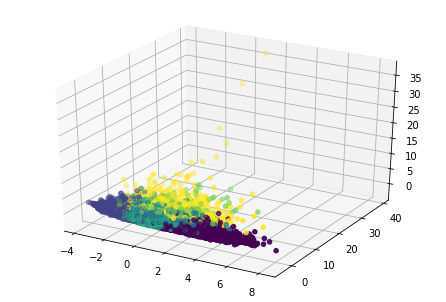

              age  time_in_hospital  num_lab_procedures  num_procedures  \
labels                                                                    
0       66.534763          8.415949           58.317271        3.544180   
1       58.567812          2.768502           35.172897        1.299041   
2       64.631907          4.327923           44.744384        0.961551   
3       71.761341          3.805744           41.666773        0.998320   
4       68.375058          3.947149           42.569309        1.213259   
5       66.039013          4.817675           49.580812        1.147691   

        num_medications  number_outpatient  number_emergency  \
labels                                                         
0             27.920256           0.132739          0.068423   
1             11.597490           0.107616          0.051384   
2             16.311281           0.148057          0.122397   
3             13.780582           0.142891          0.081046   
4             1

In [12]:
#run K-Means algorithm
kmeans_model = KMeans(n_clusters = 6, n_jobs = -1)
kmeans_model.fit(combined_data.values)
#perform PCA for plotting
kmeans_pca = PCA(n_components = 3)
kmeans_pca_data = kmeans_pca.fit_transform(combined_data)
plot_3d_scatter(kmeans_pca_data, kmeans_model.labels_)
analysis_data = combined_data.copy()
analysis_data['race'] = analysis_data[['AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'Unknown']].idxmax(axis = 1)
analysis_data['admission_type_id'] = analysis_data[['admission_type_id_Elective', 'admission_type_id_Emergency', 'admission_type_id_Newborn', 'admission_type_id_Not Available']].idxmax(axis = 1)
analysis_data[numeric_not_binary_columns] = scaler.inverse_transform(analysis_data[numeric_not_binary_columns])
analysis_data['labels'] = kmeans_model.labels_
#show means for numeric features 
print(analysis_data[numeric_not_binary_columns + ['labels']].groupby('labels').mean())
print(pd.crosstab(analysis_data['labels'], analysis_data['race']))

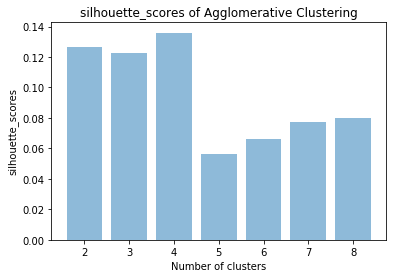

In [13]:
#Agglomerative Clustering
silhouette_scores = {}
for k in range(2,9):
    knn = kneighbors_graph(combined_data, 10, n_jobs = -1)
    Agglomerative_model = AgglomerativeClustering(n_clusters = k, connectivity = knn)
    Agglomerative_model.fit(combined_data)
    silhouette_score_val = silhouette_score(combined_data, Agglomerative_model.labels_)
    silhouette_scores.update({k:silhouette_score_val})
plt.figure(16)
plt.bar(list(silhouette_scores.keys()), list(silhouette_scores.values()), align = 'center', alpha = 0.5)
plt.xlabel("Number of clusters")
plt.ylabel("silhouette_scores")
plt.title('silhouette_scores of Agglomerative Clustering')
plt.plot()
plt.show()

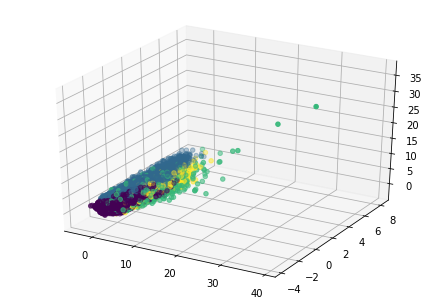

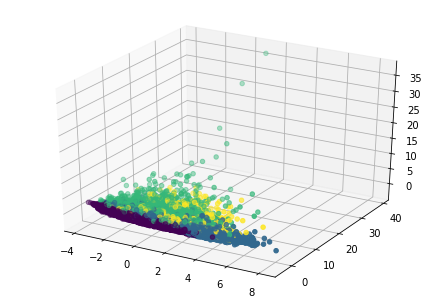

              age  time_in_hospital  num_lab_procedures  num_procedures  \
labels                                                                    
0       66.171158          3.787989           40.397496        1.387573   
1       64.339105          5.676077           48.771497        1.861102   
2       66.170293          3.891223           42.095274        1.157289   
3       68.657826          4.888242           48.243753        1.156063   

        num_medications  number_outpatient  number_emergency  \
labels                                                         
0             13.808453           0.055205          0.001039   
1             20.996124           0.087021          0.018283   
2             15.539635           1.851713          0.797074   
3             16.260616           0.239154          0.101180   

        number_inpatient  number_diagnoses  number_drugs_changed  
labels                                                            
0               0.008586      

<Figure size 432x288 with 0 Axes>

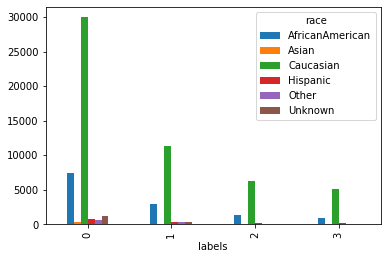

In [14]:
#run Agglomerative algorithm
knn = kneighbors_graph(combined_data, 10, n_jobs = -1)
Agglomerative_model = AgglomerativeClustering(n_clusters = 4, connectivity = knn)
Agglomerative_model.fit(combined_data)
#perform PCA for plotting
agglomerative_pca = PCA(n_components = 3)
agglomerative_pca_data = agglomerative_pca.fit_transform(combined_data)
plot_3d_scatter(agglomerative_pca_data, Agglomerative_model.labels_)
analysis_data['labels'] = Agglomerative_model.labels_
#show means for numeric features 
print(analysis_data[numeric_not_binary_columns + ['labels']].groupby('labels').mean())
plt.figure(17)
pd.crosstab(analysis_data['labels'],analysis_data['race']).plot(kind='bar')
print(pd.crosstab(analysis_data['labels'],analysis_data['change']))
print(pd.crosstab(analysis_data['labels'],analysis_data['diabetesMed']))

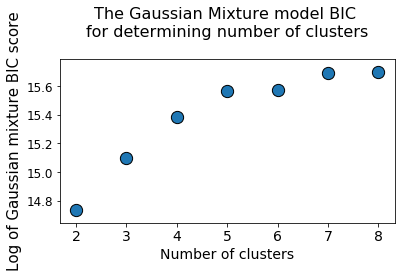

In [15]:
#Gaussian Mixture Clustering
gm_bic= []
for i in range(2,9):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(combined_data)
    gaussian_mixture_model_labels = gm.fit_predict(combined_data)
    gm_bic.append(-gm.bic(combined_data))
plt.figure(figsize=(6,3))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,9)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,9)],fontsize=14)
plt.yticks(fontsize=12)
plt.show()

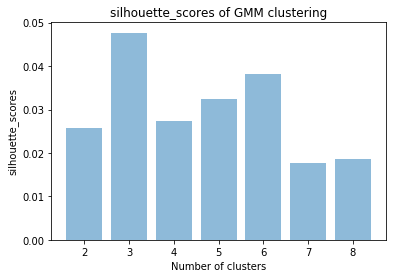

In [16]:
#Gaussian Mixture
silhouette_scores = {}
for k in range(2,9):
    gaussian_mixture_model = GaussianMixture(n_components=k)
    gaussian_mixture_model.fit(combined_data.values)
    gaussian_mixture_model_labels = gaussian_mixture_model.fit_predict(combined_data.values)
    silhouette_score_val = silhouette_score(combined_data,gaussian_mixture_model_labels)
    silhouette_scores.update({k:silhouette_score_val})  
plt.figure(18)
plt.bar(list(silhouette_scores.keys()), list(silhouette_scores.values()), align = 'center', alpha = 0.5)
plt.xlabel("Number of clusters")
plt.ylabel("silhouette_scores")
plt.title('silhouette_scores of GMM clustering')
plt.plot()
plt.show()

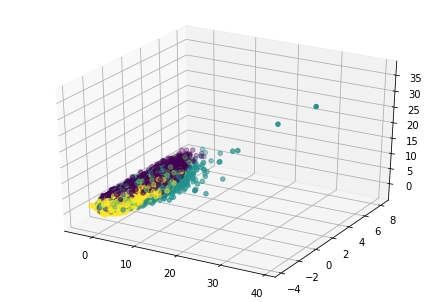

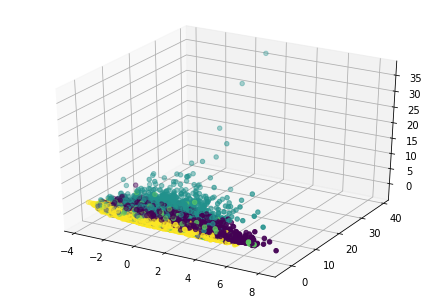

In [20]:
#run Gaussian Mixture algorithm
gaussian_mixture_model = GaussianMixture(n_components = 5).fit(combined_data)
gaussian_mixture_model_labels = gaussian_mixture_model.fit_predict(combined_data) 
#perform PCA for plotting
gaussian_mixture_pca = PCA(n_components = 3)
gaussian_mixture_pca_data = gaussian_mixture_pca.fit_transform(combined_data)
plot_3d_scatter(gaussian_mixture_pca_data, gaussian_mixture_model_labels)

In [ ]:
analysis_data = combined_data.copy()
analysis_data['labels'] = gaussian_mixture_model_labels
#show means for numeric features 
print(analysis_data[numeric_not_binary_columns + ['labels']].groupby('labels').mean())
plt.figure(19)
#print(pd.crosstab(analysis_data['labels'],analysis_data['race'])

average: 3.4836556692973946
minsample: 7.824046010856292


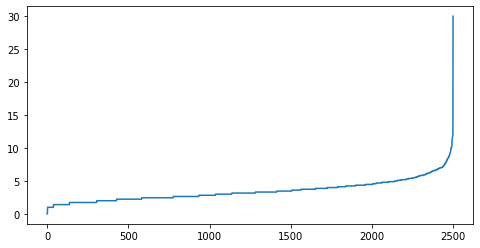

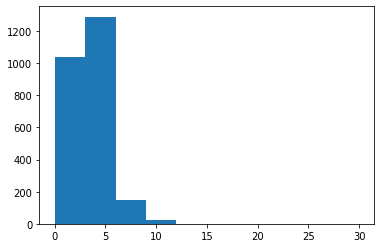

In [4]:
#DBSCAN Clustering
#KNN algorithm
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(dbscan_data)
distances, indices = nbrs.kneighbors(dbscan_data)
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.figure(figsize=(8,4))
plt.plot(distances)
print('average:', np.mean(distances, axis = None, dtype = None, out = None))
minsample = np.log(len(dbscan_data))
print('minsample:', minsample)

plt.figure(19)
plt.hist(distances)
plt.show()

Estimated number of clusters: 5
Estimated number of noise points: 398


C:\Users\tomer\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


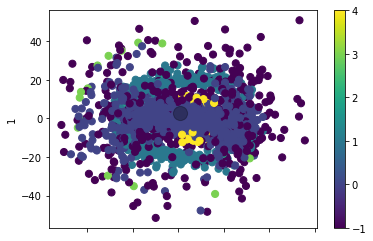

In [51]:
#run DBSCAN algorithm
db = DBSCAN(eps = 6.2 ,min_samples = 7.8)
db_label = db.fit_predict(dbscan_data)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
centers = db.core_sample_indices_
X = trans_data.loc[:, [0,1,'pred_labels']]
X.plot.scatter(x = 0, y = 1, c = db_label, s = 50, cmap = 'viridis')
plt.scatter(centers[0], centers[1], c = 'black', s = 200, alpha = 0.3)